## Fitting Ne lines in a loop
- This notebook shows how to fit all lines in a folder defined by path
- You tweak the fit for a single line, and then use this to fit all lines. You can then refit lines with high residuals/offsets differing from the rest

## Downloading locally
- The easiest way to install diad fit is by removing the #, and running this once per computer. When I update the code, you'll need to get the new tag off GitHub:
https://github.com/PennyWieser/DiadFit/tags
Right click on the top one, over the 'zip' icon, click copy link address
- Remove the # in the line below. Run only once for each computer!
![image.png](attachment:5a0e0d97-4380-4cb2-bf26-d0ab6ee7458a.png)

In [1]:
#!pip install --upgrade "https://github.com/PennyWieser/DiadFit/archive/refs/tags/0.0.19.zip"

### This imports DiadFit, and gives you the version. In all communication with Penny, make sure you say the version!

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import DiadFit as pf
pf.__version__

'0.0.20'

## Extracting metadata

In [3]:
## This to read in the time elapsed file of a Witec Series
#path=r"P:\WORK-ACAD\BERKELEY-VIBE\NEON\Ne_data\10-03-22_Ne_timeseries"
path=r"G:\My Drive\Berkeley_NEW\DiadFit_outer\docs\Examples\Repeated_Acquisitions"

timelapsed=pd.read_table(path+str('/')+'Ne_timeseries_10-03-22_elapsed-time.txt',header=None,names=['analysis#','Time (s)'])
timelapsed

,analysis#,Time (s)
0,0.0,0.087000
1,1.0,450.001007
2,2.0,900.002014
3,3.0,1350.000977
4,4.0,1800.000000
...,...,...
570,570.0,256499.968800
571,571.0,256949.968800
572,572.0,257399.968800
573,573.0,257849.968800


## Get Ne line positions for your specific laser wavelength
- At the moment, this returns any Ne lines with intensity >2000 in the NIST databook, although you can change this!

In [4]:
wavelength =532.046 # Specify the specific wavelength of your laser 
df_Ne=pf.calculate_Ne_line_positions(wavelength=wavelength, cut_off_intensity=500)
df_Ne.head()

,Raman_shift (cm-1),Intensity,Ne emission line in air
0,817.650482,1500.0,556.24416
1,818.699523,5000.0,556.27662
2,819.626623,750.0,556.30531
7,1104.288094,750.0,565.25664
8,1115.108504,750.0,565.60258


## Calculate the ideal distance between the two lines you are selecting
- This finds the closest line in the table above for the line shift you have written down

In [5]:
# Specify the approximate peak positions of the lines you are interested in
# If your drift is off the real positions, you'll have to tweak these numbers
peak1_cent=1220 # approximate position of the 1st line you are interested in
peak2_cent=1447 # Approximate position of the 2nd line you are interested in

ideal_split=pf.calculate_Ne_splitting(wavelength=wavelength, 
                                      line1_shift=peak1_cent, line2_shift=peak2_cent,
                                     cut_off_intensity=1000)
ideal_split

,Ne_Split,Line_1,Line_2,Entered Pos Line 1,Entered Pos Line 2
0,227.564622,1220.0,1447.564622,1220,1447


## Find your Ne spectra files

In [6]:
#mypath=r"P:\WORK-ACAD\BERKELEY-VIBE\NEON\Ne_data\10-03-22_Ne_timeseries"
mypath=path
filename='Ne_timeseries_10-03-22.txt'#'Ne_timeseries_10-03-22.txt'
filetype='headless_txt'
Ne_files=pf.get_data(path=mypath,
                       filename=filename, filetype=filetype)
test=np.column_stack((Ne_files[:, 0], Ne_files[:, 1]))
len(Ne_files)

1024

## Plot Ne lines to inspect
- This function allows you to inspect your spectra, and also uses scipy find peaks to get a first guess of the peak positions, which speeds up the voigt fitting in the later part of the notebook

Biggest 6 peaks:


,pos,height
64,1447.562937,47142.332030
58,1398.571000,7379.666504
80,1566.680386,6382.666504
10,1116.242122,3606.333252
30,1219.729035,3203.333252
40,1309.925385,2045.666626


selected Peak 1 Pos
1219.729035
selected Peak 2 Pos
1447.562937


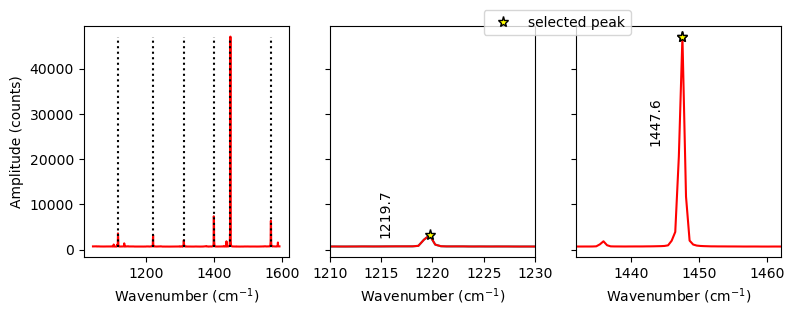

In [7]:
Ne, df_sort_Ne_trim, nearest_pk1, nearest_pk2=pf.plot_Ne_lines(path=mypath, filename=filename, filetype=filetype, 
n_peaks=6, peak1_cent=peak1_cent, peak2_cent=peak2_cent,
height=10, threshold=0.6, distance=1, prominence=10, width=1, exclude_range_1=None,
exclude_range_2=None)

## You can tweak parameters here
- The default parameters may work, you can see what those are here:
- Most important things, the number of peaks you want for 1117, and the offset for this peak (LH_offset_min) if you are fitting the 1117 line as you need 2 peaks
- By default, the function applies the fit to all the points inside the outermost background positions. This can be trimmed using x_span_pk1_override, and x_span_pk2_override
- See figure from Penny for what these parameters actually are

In [8]:
pf.Ne_peak_config()

Ne_peak_config(N_poly_pk1_baseline=1, N_poly_pk2_baseline=1, lower_bck_pk1=(-50, -25), upper_bck1_pk1=(8, 15), upper_bck2_pk1=(30, 50), lower_bck_pk2=(-44.2, -22), upper_bck1_pk2=(15, 50), upper_bck2_pk2=(50, 51), x_range_baseline=20, y_range_baseline=200, amplitude=100, x_range_peak=15, x_range_residual=7, LH_offset_mini=(1.5, 3), x_span_pk1=None, x_span_pk2=None)

- You can also overwrite any of these, the most likely things you'll want to overwrite are the background positions, or the amplitude

In [9]:
Ne_Config=pf.Ne_peak_config(amplitude=100, LH_offset_mini=[2, 5], 
lower_bck_pk1=(-60, -25), upper_bck1_pk1=[40, 70], upper_bck2_pk1=[40, 70],
lower_bck_pk2=[-40, -30], upper_bck1_pk2=[10, 15], upper_bck2_pk2=[25, 40],
x_range_peak=15, x_span_pk1=[-10, 8], x_span_pk2=[-10, 10], N_poly_pk2_baseline=2 )
Ne_Config


#For 1200_1400 peak combo copy below
# lower_bck_pk1=(-60, -25), upper_bck1_pk1=[40, 70], upper_bck2_pk1=[40, 70],
# lower_bck_pk2=[-50, -35], upper_bck1_pk2=[-15, -8], upper_bck2_pk2=[7, 20],
# x_range_peak=15, x_span_pk1=[-10, 8], x_span_pk2=[-10, 10], N_poly_pk2_baseline=2 )

#For 1117_1447 peak combo copy below
# lower_bck_pk1=(-50, -30), upper_bck1_pk1=[7, 13], upper_bck2_pk1=[50, 80],
# lower_bck_pk2=[-40, -30], upper_bck1_pk2=[10, 15], upper_bck2_pk2=[25, 40],
# x_range_peak=15, x_span_pk1=[-10, 8], x_span_pk2=[-10, 10], N_poly_pk2_baseline=2 )

#For 1200_1567 peak combo copy below
# lower_bck_pk1=(-60, -25), upper_bck1_pk1=[40, 70], upper_bck2_pk1=[40, 70],
# lower_bck_pk2=[-50, -35], upper_bck1_pk2=[12, 18], upper_bck2_pk2=[12, 18],


#For 1200_1587 peak combo copy below
# lower_bck_pk1=(-60, -25), upper_bck1_pk1=[40, 70], upper_bck2_pk1=[40, 70],
# lower_bck_pk2=[-8, -3], upper_bck1_pk2=[4, 5], upper_bck2_pk2=[4,5],
# x_range_peak=15, x_span_pk1=[-10, 8], x_span_pk2=[-10, 10], N_poly_pk2_baseline=1 )

#For 1117_1587 peak combo copy below
#lower_bck_pk1=(-50, -30), upper_bck1_pk1=[7, 13], upper_bck2_pk1=[50, 80],
#  lower_bck_pk2=[-8, -3], upper_bck1_pk2=[4, 5], upper_bck2_pk2=[4,5],
# x_range_peak=15, x_span_pk1=[-10, 8], x_span_pk2=[-10, 10], N_poly_pk2_baseline=1 )

Ne_peak_config(N_poly_pk1_baseline=1, N_poly_pk2_baseline=2, lower_bck_pk1=(-60, -25), upper_bck1_pk1=[40, 70], upper_bck2_pk1=[40, 70], lower_bck_pk2=[-40, -30], upper_bck1_pk2=[10, 15], upper_bck2_pk2=[25, 40], x_range_baseline=20, y_range_baseline=200, amplitude=100, x_range_peak=15, x_range_residual=7, LH_offset_mini=[2, 5], x_span_pk1=[-10, 8], x_span_pk2=[-10, 10])

,filename,pk2_peak_cent,error_pk2,pk1_peak_cent,error_pk1,deltaNe,Ne_Corr,Ne_Corr_min,Ne_Corr_max,residual_pk2,residual_pk1,residual_pk1+pk2
0,Ne_timeseries_10-03-22.txt,1447.474905,0.00461,1219.539641,0.00263,227.935264,0.998374,0.998342,0.998406,198.541572,15.902323,214.443895


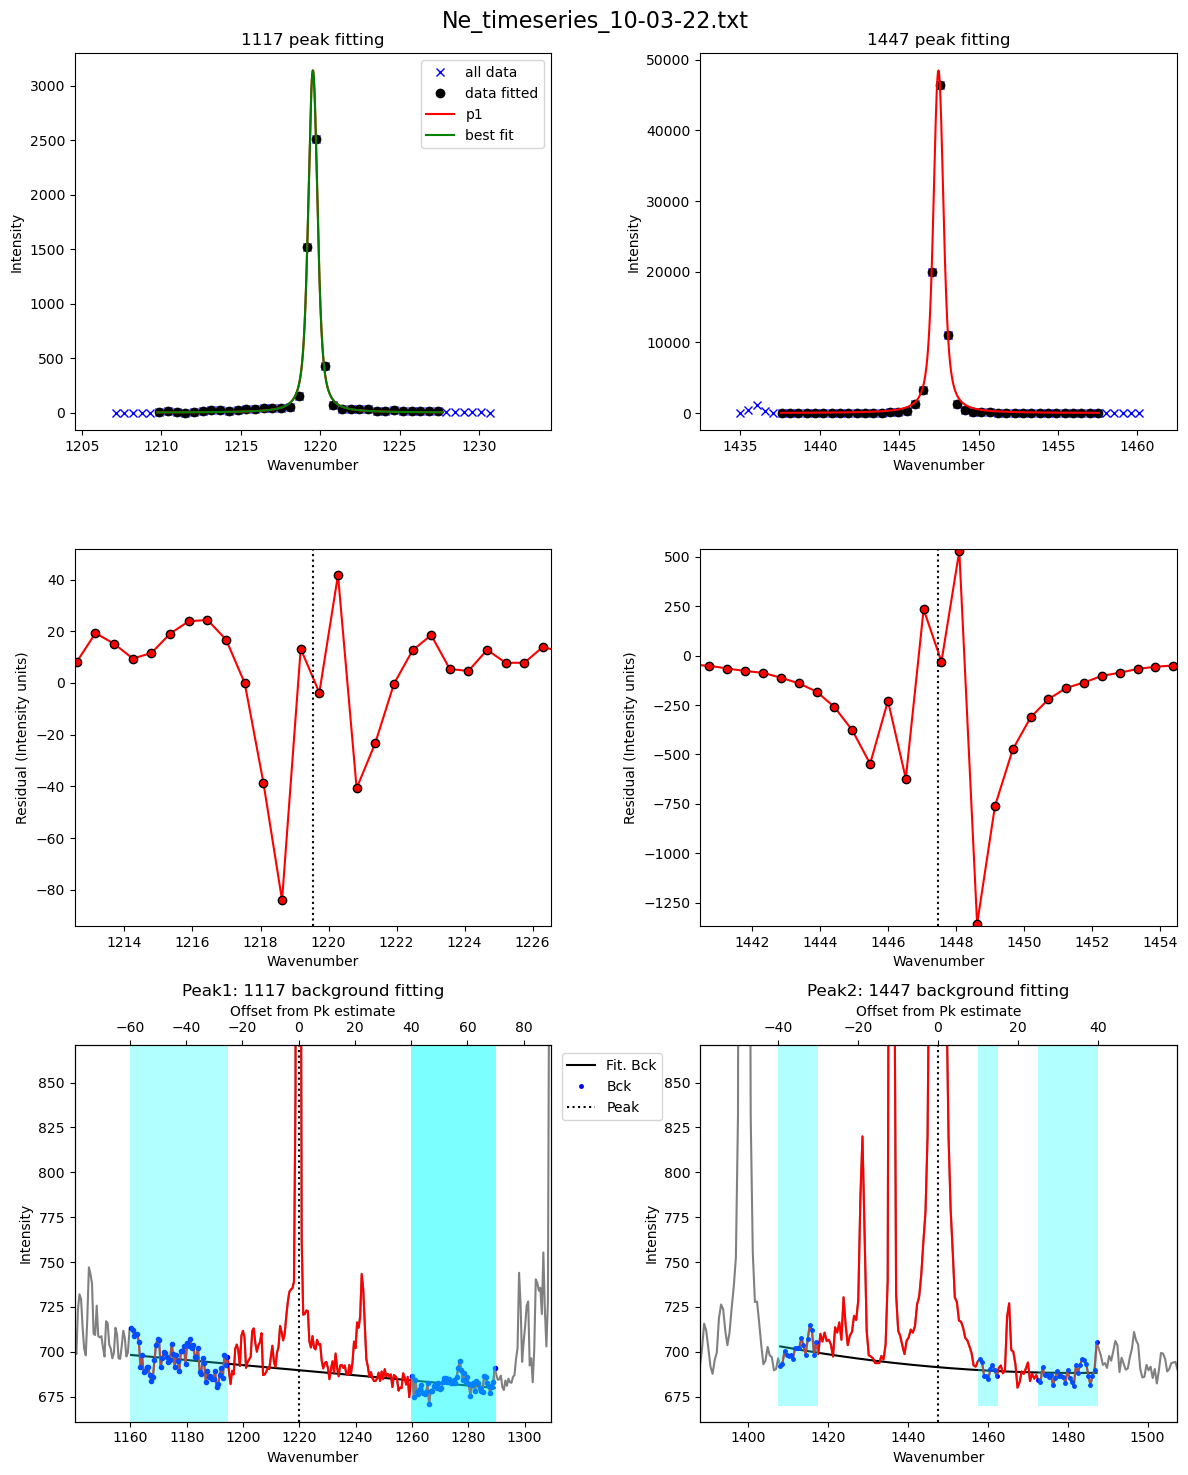

In [10]:
# You also need to set whether you want 1 peak or 2 for the LH diad
if peak1_cent==1117:
    peaks_1=2
else:
    peaks_1=1

#peaks_1=2
prefix=False
df_test=pf.fit_Ne_lines(  
    config=Ne_Config, peaks_1=peaks_1,
    Ne=Ne, filename=filename, path=mypath, prefix=prefix,
    Ne_center_1=nearest_pk1, Ne_center_2=nearest_pk2,
    DeltaNe_ideal=ideal_split['Ne_Split'])                                                                 
                                                                     
        
display(df_test)

## Now you can loop over all files using these parameters
- Most important thing you can change is plot_figure=False, much quicker, but wont save or show figures, plot_figure=True will)
- If you need, you can add other parameters in the loop here. 

In [40]:
Ne_files_2=Ne_files[:, 0:1000]
Ne_files_2

array([[1042.545976,  719.      ,  718.      , ...,  720.333313,
         725.      ,  723.666687],
       [1043.112314,  727.      ,  725.666687, ...,  723.      ,
         725.      ,  728.666687],
       [1043.678594,  725.      ,  730.666687, ...,  721.666687,
         727.333313,  723.      ],
       ...,
       [1591.175541,  741.333313,  745.333313, ...,  738.666687,
         740.666687,  740.666687],
       [1591.684529,  732.      ,  735.      , ...,  728.      ,
         734.333313,  734.      ],
       [1592.193462,  724.      ,  734.333313, ...,  729.      ,
         724.333313,  725.333313]])

In [41]:
df2=pf.loop_Ne_lines(files=Ne_files_2, path=mypath, filetype='headless_txt',
                  config=Ne_Config, peaks_1=peaks_1, Ne=Ne, Ne_center_1=nearest_pk1,
                  Ne_center_2=nearest_pk2, DeltaNe_ideal=ideal_split['Ne_Split'], 
                  plot_figure=False, save_clipboard=False, single_acq=True)

100%|████████████████████████████████████████████████████████████████████████████████| 574/574 [00:30<00:00, 18.92it/s]


In [42]:
df2

,filename,pk2_peak_cent,error_pk2,pk1_peak_cent,error_pk1,deltaNe,Ne_Corr,Ne_Corr_min,Ne_Corr_max,residual_pk2,residual_pk1,residual_pk1+pk2
0,0,1447.474905,0.00461,1219.539641,0.00263,227.935264,0.998374,0.998342,0.998406,198.541572,15.902323,214.443895
1,1,1447.483998,0.00469,1219.540685,0.00258,227.943313,0.998339,0.998307,0.998371,194.921027,16.082022,211.003049
2,2,1447.495296,0.00477,1219.555956,0.00284,227.939340,0.998356,0.998323,0.998389,193.660057,17.888758,211.548815
3,3,1447.506530,0.00485,1219.562943,0.00275,227.943587,0.998337,0.998304,0.998371,189.735771,17.393633,207.129404
4,4,1447.518795,0.00476,1219.573042,0.00284,227.945753,0.998328,0.998295,0.998361,179.467824,17.724456,197.192280
...,...,...,...,...,...,...,...,...,...,...,...,...
569,569,1448.272572,0.12500,1219.819453,0.00304,228.453119,0.996111,0.995553,0.996669,890.862253,15.473820,906.336073
570,570,1447.853103,0.00236,1219.817794,0.00300,228.035308,0.997936,0.997912,0.997959,130.728059,14.724511,145.452570
571,571,1447.852765,0.00239,1219.827729,0.00304,228.025036,0.997981,0.997957,0.998005,133.646515,16.538491,150.185006
572,572,1447.852697,0.00234,1219.821360,0.00303,228.031337,0.997953,0.997930,0.997977,129.753687,16.273618,146.027305


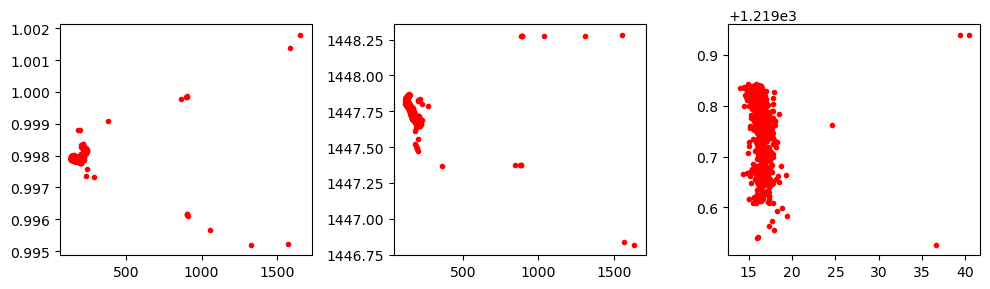

In [43]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10,3))
ax1.plot( df2['residual_pk1+pk2'], df2['Ne_Corr'],'.r')
ax2.plot( df2['residual_pk2'],df2['pk2_peak_cent'], '.r')
ax3.plot(df2['residual_pk1'],df2['pk1_peak_cent'],  '.r')
fig.tight_layout()

In [44]:
df3=df2.loc[(df2['residual_pk1']<25)&(df2['residual_pk2']<300)]


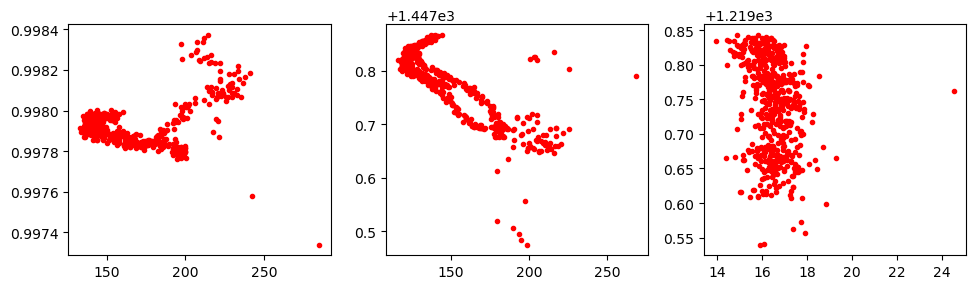

In [45]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10,3))
ax1.plot( df3['residual_pk1+pk2'], df3['Ne_Corr'],'.r')
ax2.plot( df3['residual_pk2'],df3['pk2_peak_cent'], '.r')
ax3.plot(df3['residual_pk1'],df3['pk1_peak_cent'],  '.r')
fig.tight_layout()

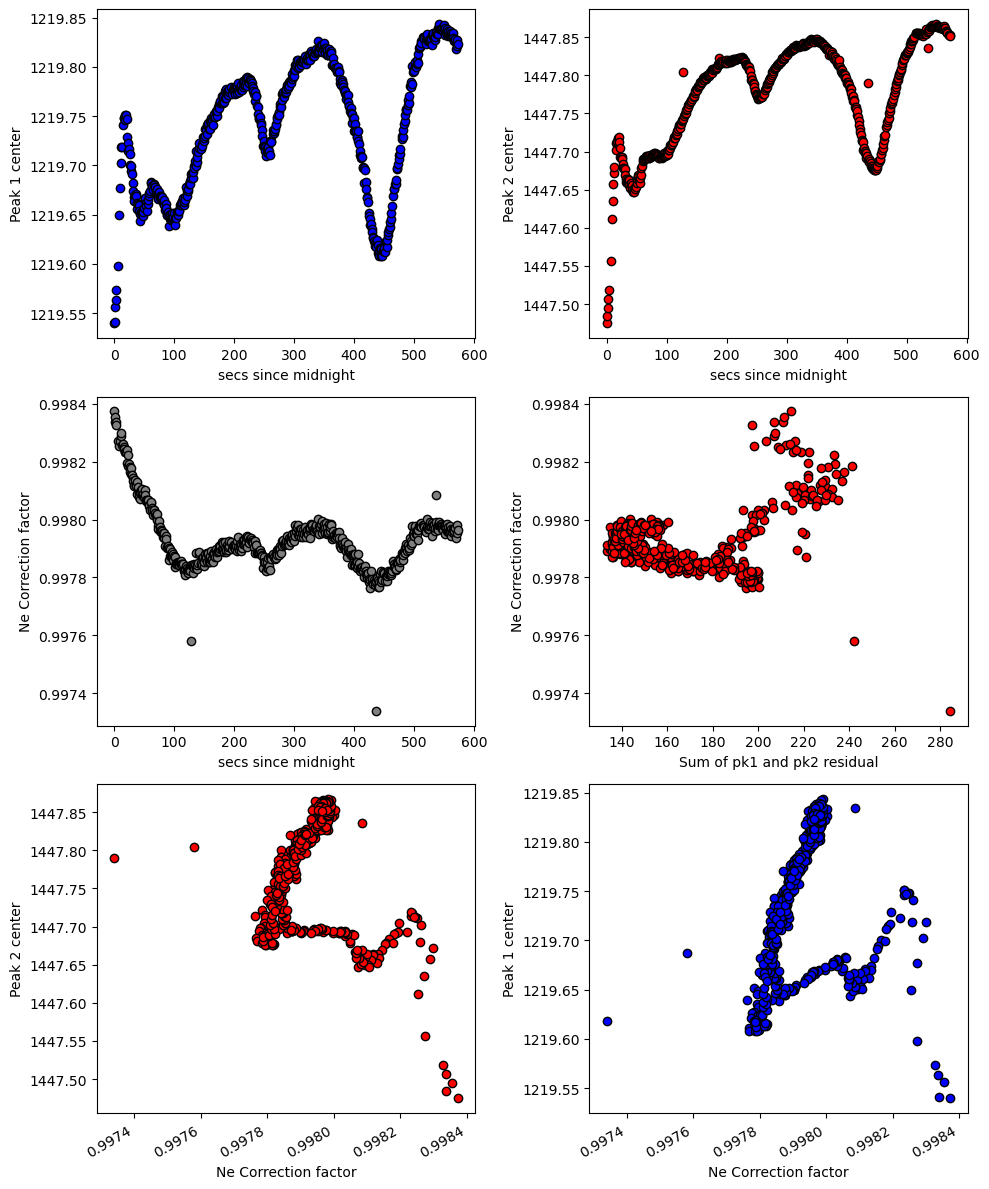

In [47]:
fig=pf.plot_Ne_corrections(df=df3, x_axis=df3.index,
                      x_label='secs since midnight')

# If any are weird, can fit again here
- If you refit, you'll have to replace the value in the saved dataframe

In [340]:
# # Which file
# filename2=Ne_files[1]  # Or you could put a string here, like 'NE1.txt' 

# # Tweak fit

# Ne_Config2=pf.Ne_peak_config(amplitude=100, LH_offset_mini=[2, 5], 
# lower_bck_pk1=(-50, -30), upper_bck1_pk1=[7, 13], upper_bck2_pk1=[50, 80],
# lower_bck_pk2=[-40, -30], upper_bck1_pk2=[15, 50], upper_bck2_pk2=[50, 80],
# x_range_peak=15, x_span_pk1=[-10, 8], x_span_pk2=[-10, 10])
# Ne_Config

# # You also need to set whether you want 1 peak or 2 for the LH diad
# peaks_1=2

# df_test=pf.fit_Ne_lines(  
#     config=Ne_Config2, peaks_1=peaks_1,
#     Ne=Ne, filename=filename2, path=mypath, prefix=prefix,
#     Ne_center_1=nearest_pk1, Ne_center_2=nearest_pk2,
#     DeltaNe_ideal=ideal_split['Ne_Split'])                                                                 
                                                                     
        
# #config: Ne_peak_config=Ne_peak_config(),

## Stitching meta data with Ne line data

## Now combining them

In [13]:
## This adds the Time column from the elapsed time file from Witec series and the Emission line combination (4 stitching and quick plotting later).
df_combo=df2.copy()
nm=str(peak1_cent)+'_'+str(peak2_cent) #string name for excel file

if 'Time (s)' not in df_combo.columns:
    df_combo.insert(1,'Time (s)',timelapsed['Time (s)'])

if 'Emissionlines' not in df_combo.columns:
    df_combo.insert(1,'Emissionlines',nm)

outputfolder=r'P:\WORK-ACAD\BERKELEY-VIBE\NEON\Ne_notebooks\Output'
df_combo.to_excel(outputfolder+'/'+nm+".xlsx")
df_combo

OSError: Cannot save file into a non-existent directory: 'P:\WORK-ACAD\BERKELEY-VIBE\NEON\Ne_notebooks\Output'

In [403]:
### This stitches all the outputs from previous step (if you chose different combinations of Ne lines, for comparison)
import glob
path = outputfolder #Folder where the files from the previous step are contained

filenames = glob.glob(path + "\*.xlsx")
print('File names:', filenames)

appended_data = []

for infile in filenames:
    data = pd.read_excel(infile)
    if 'Unnamed: 0'  in data.columns:
        data=data.drop(columns=['Unnamed: 0'])
    if 'Unnamed: 0.1'  in data.columns:
        data=data.drop(columns=['Unnamed: 0.1'])
    # store DataFrame in list
    appended_data.append(data)
    # print(appended_data)
# see pd.concat documentation for more info
app = pd.concat(appended_data)

# write DataFrame to an excel sheet 
app.to_excel(r'P:\WORK-ACAD\BERKELEY-VIBE\NEON\Ne_notebooks\10-03-22_tseries_compile.xlsx')
app

File names: ['P:\\WORK-ACAD\\BERKELEY-VIBE\\NEON\\Ne_notebooks\\Output\\1117_1587.xlsx', 'P:\\WORK-ACAD\\BERKELEY-VIBE\\NEON\\Ne_notebooks\\Output\\1220_1587.xlsx', 'P:\\WORK-ACAD\\BERKELEY-VIBE\\NEON\\Ne_notebooks\\Output\\1220_1447.xlsx', 'P:\\WORK-ACAD\\BERKELEY-VIBE\\NEON\\Ne_notebooks\\Output\\1117_1567.xlsx', 'P:\\WORK-ACAD\\BERKELEY-VIBE\\NEON\\Ne_notebooks\\Output\\1220_1567.xlsx', 'P:\\WORK-ACAD\\BERKELEY-VIBE\\NEON\\Ne_notebooks\\Output\\1117_1400.xlsx', 'P:\\WORK-ACAD\\BERKELEY-VIBE\\NEON\\Ne_notebooks\\Output\\1220_1400.xlsx', 'P:\\WORK-ACAD\\BERKELEY-VIBE\\NEON\\Ne_notebooks\\Output\\1117_1447.xlsx']


,filename,Emissionlines,Time (s),pk2_peak_cent,error_pk2,pk1_peak_cent,error_pk1,deltaNe,Ne_Corr,Ne_Corr_min,Ne_Corr_max,residual_pk2,residual_pk1
0,0,1117_1587,0.087000,1587.439277,0.00746,1116.462746,NaN,470.976532,0.999503,NaN,NaN,9.271956,17.504914
1,1,1117_1587,450.001007,1587.443274,0.00862,1116.471687,NaN,470.971587,0.999513,NaN,NaN,10.210045,16.663692
2,2,1117_1587,900.002014,1587.457435,0.00861,1116.473413,NaN,470.984023,0.999487,NaN,NaN,10.060672,16.120965
3,3,1117_1587,1350.000977,1586.924198,0.32200,1116.476367,NaN,470.447831,1.000626,NaN,NaN,50.677860,17.276005
4,4,1117_1587,1800.000000,1587.481494,0.00995,1116.483763,NaN,470.997731,0.999458,NaN,NaN,10.890967,16.874143
...,...,...,...,...,...,...,...,...,...,...,...,...,...
569,569,1117_1447,256049.968800,1448.272572,0.12400,1116.600983,NaN,331.671589,0.996400,NaN,NaN,890.862692,26.073822
570,570,1117_1447,256499.968800,1447.853103,0.00236,1116.600786,NaN,331.252317,0.997661,NaN,NaN,130.728059,27.666077
571,571,1117_1447,256949.968800,1447.852765,0.00239,1116.606570,NaN,331.246195,0.997680,NaN,NaN,133.646515,26.893229
572,572,1117_1447,257399.968800,1447.852697,0.00234,1116.596144,NaN,331.256553,0.997649,NaN,NaN,129.753687,27.202933


## Now lets inspect what our Ne correction factors actually look like

In [25]:
help(pf.plot_Ne_corrections)

Help on function plot_Ne_corrections in module DiadFit.ne_lines:

plot_Ne_corrections(df=None, x_axis=None, x_label='index', marker='o', mec='k', mfc='r')
    ## Plot to help inspect which Ne lines to discard



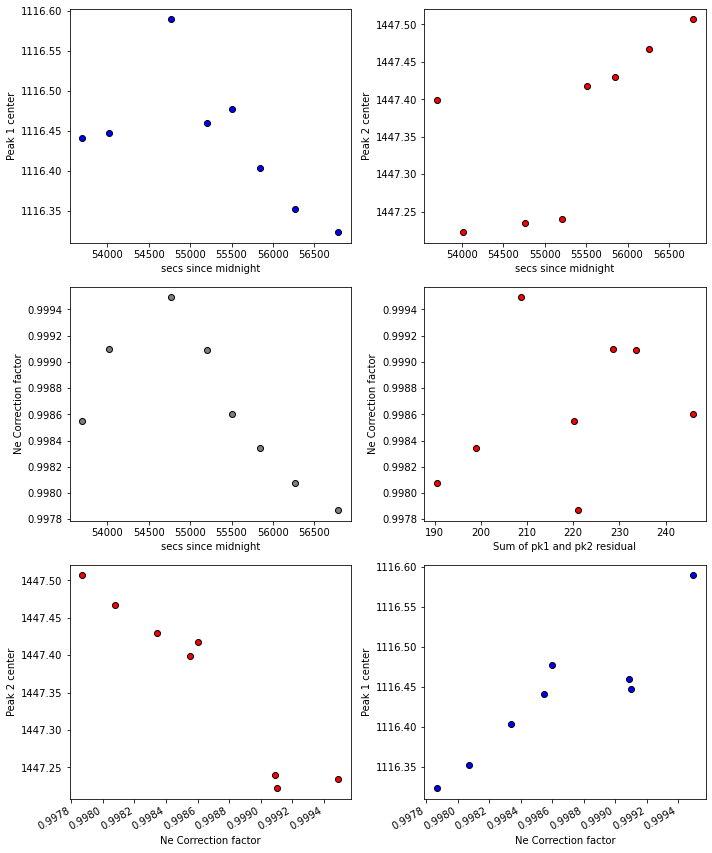

In [26]:
fig=pf.plot_Ne_corrections(df=df_combo, x_axis=df_combo['sec since midnight'],
                      x_label='secs since midnight')

## Now lets make a regression against time

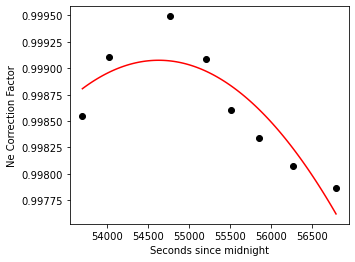

In [27]:
model=pf.reg_Ne_lines_time(df=df_combo, N_poly=2, fit='poly')

## Charlotte - would be good to make an option to have a regression in 2 parts, as this is obvious rubbish
- I have pasted the fitting function below, if you can work out how to do a 2 part linear regression based on a user-entered x cordinate, outputed as a single PF that would be great.

In [ ]:
from scipy.interpolate import interp1d
def reg_Ne_lines_time(df, fit='poly', N_poly=None, spline_fit=None):
    """
    Parameters
    -----------
    df: pd.DataFrame
        dataframe of stitched Ne fits and metadata information from WITEC,
        must have columns 'sec since midnight' and 'Ne_Corr'

    fit: float 'poly', or 'spline'
        If 'poly':
            N_poly: int, degree of polynomial to fit (1 if linear)
        if 'spline':
            spline_fit: The string has to be one of:
        ‘linear’, ‘nearest’, ‘nearest-up’, ‘zero’, ‘slinear’,
        ‘quadratic’, ‘cubic’, ‘previous’. Look up documentation for interpld

    Returns
    -----------
    figure of fit and data used to make it
    Pf: fit model, can be used to evaluate unknown data (only within x range of df for spline fits).




    """
    Px=np.linspace(np.min(df['sec since midnight']), np.max(df['sec since midnight']),
                         101)
    if fit=='poly':
        Pf = np.poly1d(np.polyfit(df['sec since midnight'], df['Ne_Corr'],
                              N_poly))

    if fit == 'spline':
            Pf = interp1d(df['sec since midnight'], df['Ne_Corr'], kind=spline_fit)

    Py=Pf(Px)

    fig, (ax1) = plt.subplots(1, 1, figsize=(5, 4))
    ax1.plot(df['sec since midnight'], df['Ne_Corr'], 'ok')
    ax1.plot(Px, Py, '-r')
    ax1.set_xlabel('Seconds since midnight')
    ax1.set_ylabel('Ne Correction Factor')

    ax1.ticklabel_format(useOffset=False)


    return Pf

## SAving as pickle, can then load as a pickle

In [29]:
import pickle
with open('Ne_Line_Regression_ExampleVIBE.pck', 'wb') as file_handle:
    pickle.dump(model, file_handle)

In [31]:
with open('Ne_Line_Regression_ExampleVIBE.pck', 'rb') as file_handle:
    my_loaded_model = pickle.load(file_handle)

poly1d([-3.11915026e-10,  3.40787483e-05,  6.82445848e-02])

## You can then load these pickles into the notebook where you fit your Diad data|